## Travel Time Situation for Distance (Scenario 1)
* Author: Callie Clark
* Last Updated: 6/8/2024

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import networkx as nx
import osmnx as ox
import json

%matplotlib inline
ox.__version__

from scipy.spatial import cKDTree
from TT_functions import *
import random

from haversine import haversine, Unit


# Calculate TT

In [3]:
census_tract=pd.read_csv('geo_files/census_tract_centroid.csv',index_col=0)
census_tract.set_index(keys='GEOID',inplace=True)
CT_gpd = gpd.GeoDataFrame(
    census_tract, geometry=gpd.points_from_xy(census_tract.lon, census_tract.lat))
CT_gpd=CT_gpd.set_crs(2263)
CT_gpd.head()

,BoroName,NTA2020,lon,lat,centroid,geometry
GEOID,,,,,,
36061000100,Manhattan,MN0191,-74.042340,40.695673,POINT (-74.04233991488555 40.69567298240604),POINT (-74.042 40.696)
36061000201,Manhattan,MN0301,-73.985848,40.711869,POINT (-73.98584800028144 40.71186871871548),POINT (-73.986 40.712)
36061000600,Manhattan,MN0301,-73.989477,40.711951,POINT (-73.9894767752886 40.711950582311424),POINT (-73.989 40.712)
36061001401,Manhattan,MN0302,-73.987332,40.715160,POINT (-73.98733213277733 40.715160475095416),POINT (-73.987 40.715)
36061001402,Manhattan,MN0302,-73.985882,40.717513,POINT (-73.98588163638996 40.71751329107455),POINT (-73.986 40.718)


In [4]:
fp_df=gpd.read_file("FP_data/food_pantry_schedule_final.geojson",index_col=0)
fp_df.set_index('id',inplace=True)
fp_df=fp_df.set_crs(2263,allow_override=True) #use projected crs for distance calculation
fp_df.head(n=1)


,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,Mo_open,...,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close,Hours_parsed,hours_open,geometry
id,,,,,,,,,,,,,,,,,,,,,
84142,St. Albans Baptist Church,196-20 119th Ave,"Sa 10:00AM-12:00PM ""every first and third Satu...","Sa 10:00AM-12:00PM ""every first and third Satu...",NaT,40.690698,-73.753923,- Will not refuse anyone even if they don't ha...,Queens,NaN,...,NaN,NaN,NaN,10.0,12.0,NaN,NaN,1.0,2.0,POINT (-73.754 40.691)


In [5]:
#calculate for closest
idx_nearest=ckdnearest(CT_gpd, fp_df,k_nearest=1)
#get average tt for closest three 
idx_nearest_3=ckdnearest(CT_gpd, fp_df,k_nearest=3)
dist_haver=[]
dist_haver_3=[]
for i in range(len(idx_nearest_3)):
    dist_haver_iter=[]
    for j in range(3):
        dist_haver_iter.append(haversine((CT_gpd.iloc[i].lat,CT_gpd.iloc[i].lon),(fp_df.iloc[idx_nearest_3[i][j]].lat,fp_df.iloc[idx_nearest_3[i][j]].lng), unit=Unit.MILES))
    dist_haver_3.append(np.mean(dist_haver_iter))
    dist_haver.append(np.min(dist_haver_iter))

In [6]:
CT_gpd['FP_nearest']=fp_df.iloc[idx_nearest].index
CT_gpd['FP_nearest_dist']=dist_haver
CT_gpd['FP_tt']=[round(i*(60/2.8),2) for i in dist_haver] #takes miles and applies walking speed to get distance in minutes 
CT_gpd['FP_tt_3']=[round(i*(60/2.8),2) for i in dist_haver_3] #takes miles and applies walking speed to get distance in minutes 
CT_gpd['index']=1
CT_gpd['index'].loc[CT_gpd['FP_nearest_dist']>1.0]=0
CT_gpd.head()

/tmp/ipykernel_54830/4162974941.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  CT_gpd['index'].loc[CT_gpd['FP_nearest_dist']>1.0]=0
/tmp/ipykernel_54830/4162974941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,BoroName,NTA2020,lon,lat,centroid,geometry,FP_nearest,FP_nearest_dist,FP_tt,FP_tt_3,index
GEOID,,,,,,,,,,,
36061000100,Manhattan,MN0191,-74.042340,40.695673,POINT (-74.04233991488555 40.69567298240604),POINT (-74.042 40.696),FPC-528,1.585461,33.97,36.39,0
36061000201,Manhattan,MN0301,-73.985848,40.711869,POINT (-73.98584800028144 40.71186871871548),POINT (-73.986 40.712),85193,0.175677,3.76,5.79,1
36061000600,Manhattan,MN0301,-73.989477,40.711951,POINT (-73.9894767752886 40.711950582311424),POINT (-73.989 40.712),FPC-626,0.223151,4.78,6.63,1
36061001401,Manhattan,MN0302,-73.987332,40.715160,POINT (-73.98733213277733 40.715160475095416),POINT (-73.987 40.715),Plentiful-1200,0.093952,2.01,2.98,1
36061001402,Manhattan,MN0302,-73.985882,40.717513,POINT (-73.98588163638996 40.71751329107455),POINT (-73.986 40.718),FPC-625,0.083548,1.79,2.28,1


In [7]:
CT_gpd[['FP_nearest', 'FP_tt', 'FP_tt_3']]

,FP_nearest,FP_tt,FP_tt_3
GEOID,,,
36061000100,FPC-528,33.97,36.39
36061000201,85193,3.76,5.79
36061000600,FPC-626,4.78,6.63
36061001401,Plentiful-1200,2.01,2.98
36061001402,FPC-625,1.79,2.28
...,...,...,...
36047066600,85234,29.09,32.59
36061002400,FPC-627,3.19,5.81
36047055500,83174,8.60,12.20


In [43]:
CT_gpd[['FP_nearest', 'FP_tt', 'FP_tt_3']].to_csv('travel_time_df/df_tt_S1.csv')

<Axes: >

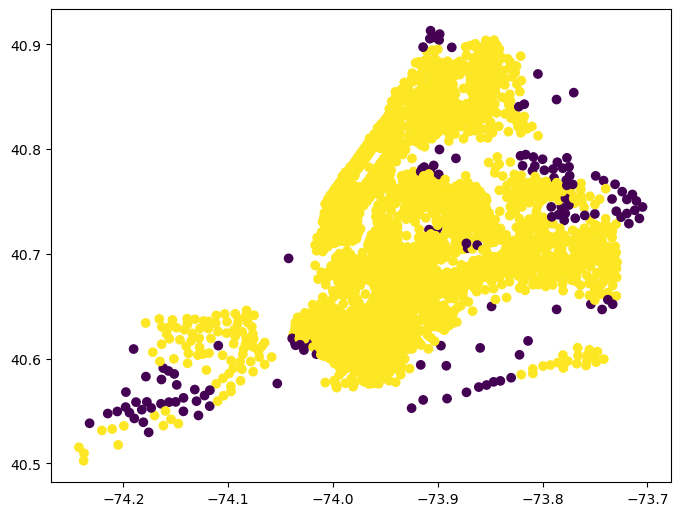

In [41]:
fig,(ax1)=plt.subplots(ncols=(1),nrows=(1),figsize=(8,8)) #standardize scale!!
CT_gpd.plot(column='index',ax=ax1)


<Axes: >

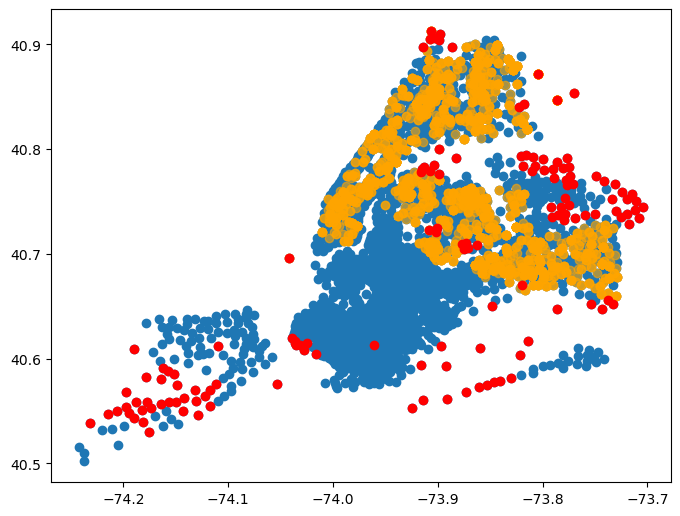

In [14]:
fig,(ax1)=plt.subplots(ncols=(1),nrows=(1),figsize=(8,8)) #standardize scale!!
CT_gpd.plot(ax=ax1)
CT_gpd.iloc[idx_nearest].plot(color='orange',ax=ax1,alpha=0.6)
CT_gpd[CT_gpd['Nearest_FP_dist']>1].plot(color='red',ax=ax1)